<a href="https://colab.research.google.com/github/jhcool1988/teamdata/blob/master/marketpredDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def get_data():
    #get train data
    train_data_path ='https://raw.githubusercontent.com/jhcool1988/teamdata/master/soccerVFm.csv'
    train = pd.read_csv(train_data_path)
    train = train[['mvpr','goal','assist','sh','int','drib']]
    #get test data
    test_data_path ='https://raw.githubusercontent.com/jhcool1988/teamdata/master/soccerVFm.csv'
    test = pd.read_csv(test_data_path)
    test = test[['goal','assist','sh','int','drib']]
    return train , test

In [ ]:
def get_combined_data():
  #reading train data
  train , test = get_data()

  target = train.mvpr
  train.drop(['mvpr'],axis = 1 , inplace = True)

  combined = train.append(test)
  combined.reset_index(inplace=True)
  combined.drop(['index'], inplace=True, axis=1)
  return combined, target

In [ ]:
#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

In [ ]:
#Combine train and test data to process them together
combined, target = get_combined_data()

In [ ]:
combined.describe()

,goal,assist,sh,int,drib
count,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000
mean,6.007595,2.868354,38.935949,14.927426,4.903797
std,6.099286,2.904337,25.117012,11.564993,5.260863
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,23.000000,6.000000,1.000000
50%,4.000000,2.000000,36.200000,13.000000,3.000000
75%,9.000000,4.000000,49.000000,21.000000,7.000000
max,36.000000,21.000000,194.000000,70.000000,39.000000


In [ ]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [ ]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [ ]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 5
Number of nun-numerical columns with no nan values : 0


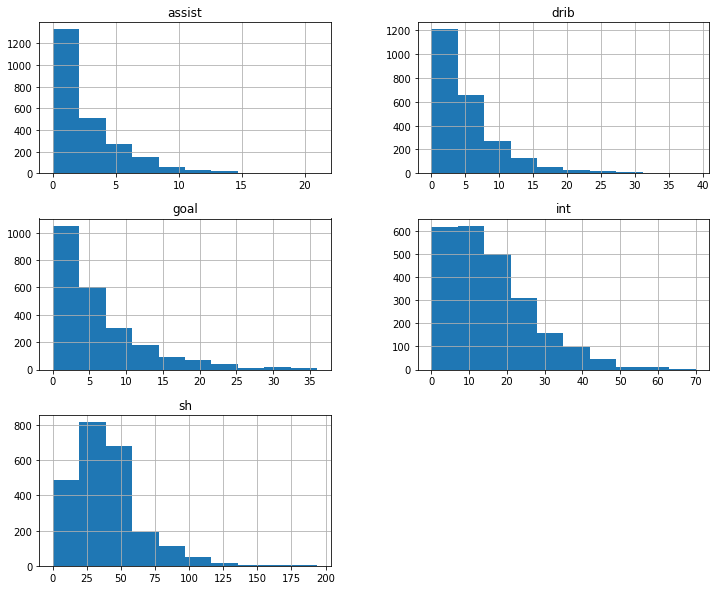

In [ ]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

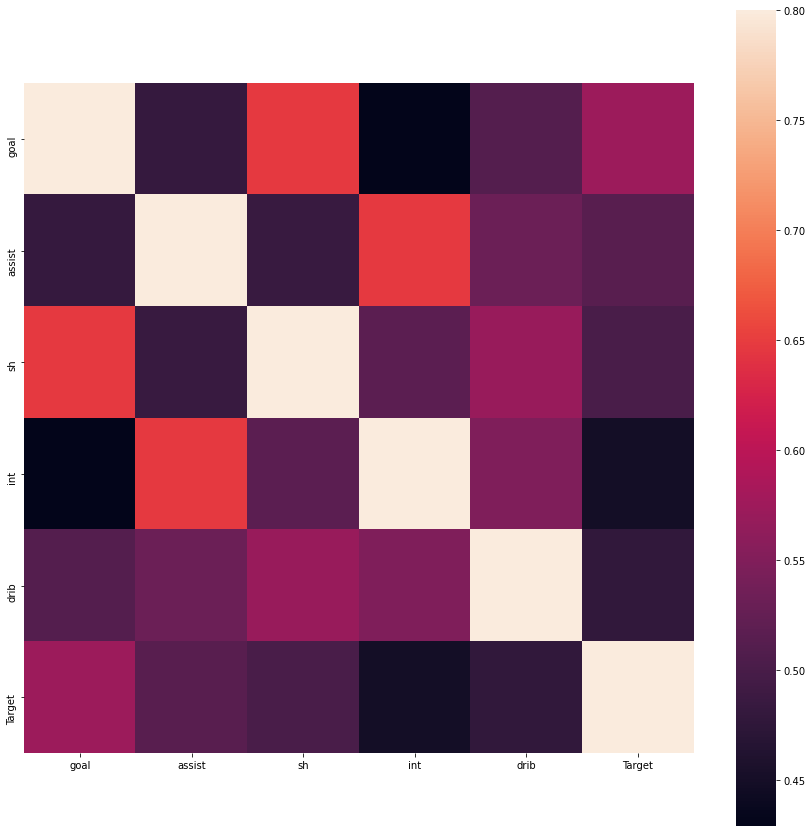

In [ ]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [ ]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

In [ ]:
print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 5 columns before encoding categorical features
There are 5 columns after encoding categorical features


In [ ]:
def split_combined():
    global combined
    train = combined[:800]
    test = combined[800:]

    return train , test 

In [ ]:
train, test = split_combined()

In [63]:
NN_model = Sequential()

NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))


NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

history = NN_model.fit(train, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

NN_model.summary()

Epoch 1/500
19/20 [===========================>..] - ETA: 0s - loss: 24915778.0000 - mean_absolute_error: 24915778.0000
Epoch 00001: val_loss improved from inf to 11869534.00000, saving model to Weights-001--11869534.00000.hdf5
20/20 [==============================] - 0s 11ms/step - loss: 24710648.0000 - mean_absolute_error: 24710648.0000 - val_loss: 11869534.0000 - val_mean_absolute_error: 11869534.0000
Epoch 2/500
19/20 [===========================>..] - ETA: 0s - loss: 24388452.0000 - mean_absolute_error: 24388452.0000
Epoch 00002: val_loss improved from 11869534.00000 to 11867190.00000, saving model to Weights-002--11867190.00000.hdf5
20/20 [==============================] - 0s 5ms/step - loss: 24709546.0000 - mean_absolute_error: 24709546.0000 - val_loss: 11867190.0000 - val_mean_absolute_error: 11867190.0000
Epoch 3/500
19/20 [===========================>..] - ETA: 0s - loss: 24772474.0000 - mean_absolute_error: 24772474.0000
Epoch 00003: val_loss improved from 11867190.00000 to 

In [58]:
# Load wights file of the best model :
# wights_file = 'Weights-478--18738.19831.hdf5' # choose the best checkpoint 
# NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [64]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':pd.read_csv('test.csv').Id,'SalePrice':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

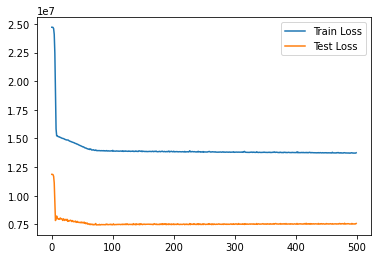

In [65]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()

In [66]:
pred = NN_model.predict(test)

In [67]:
# 골 어시 슈팅 인터셉트 드리블수
mydata = np.array([[11,10,81,15,15]])
# mydata = scaler.fit_transform(mydata)
mydata

array([[11, 10, 81, 15, 15]])

In [68]:
# 예측 실시
# pred = model.predict(X_train_t)
pred = NN_model.predict(mydata)

pred

array([[38755260.]], dtype=float32)

In [69]:

marketvaluepred = 37397468 * 1.027 * 1.025 * 1.018 * 1.018
marketvaluepred

40797360.32446751